In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades\haarcascade_eye.xml')

In [3]:
def get_cropped_image_if_2_eyes(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

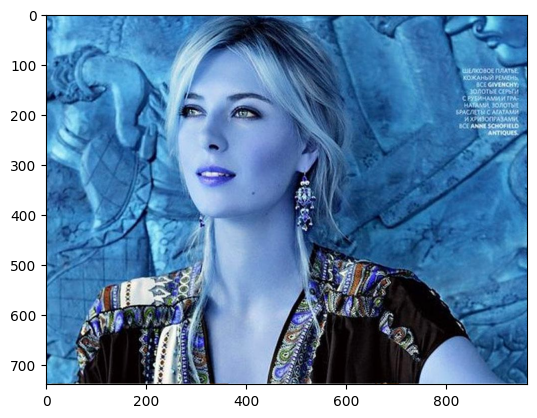

In [4]:
original_image = cv2.imread('test_image.jpg')
plt.imshow(original_image)

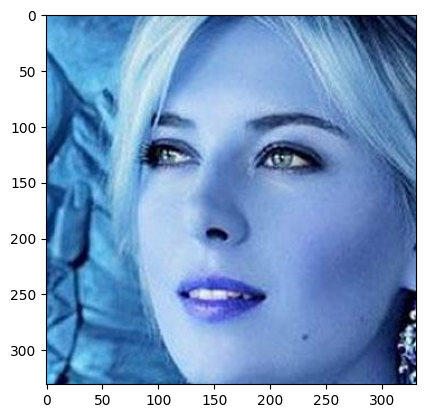

In [5]:
cropped_image = get_cropped_image_if_2_eyes('test_image.jpg')
plt.imshow(cropped_image)

In [6]:
dataset_path = 'D:\project\celebrity_face_recognition\CelebrityFaceRecognition_codebasics\images_dataset'
cropped_path = 'D:\project\celebrity_face_recognition\model\cropped'

In [7]:
print(dataset_path.split('\\')[-1])

images_dataset


In [8]:
import os

img_dirs = []
for entry in os.scandir(dataset_path):
    if entry.is_dir():
        img_dirs.append(os.path.join(dataset_path,entry))

img_dirs

['D:\\project\\celebrity_face_recognition\\CelebrityFaceRecognition_codebasics\\images_dataset\\lionel_messi',
 'D:\\project\\celebrity_face_recognition\\CelebrityFaceRecognition_codebasics\\images_dataset\\maria_sharapova',
 'D:\\project\\celebrity_face_recognition\\CelebrityFaceRecognition_codebasics\\images_dataset\\roger_federer',
 'D:\\project\\celebrity_face_recognition\\CelebrityFaceRecognition_codebasics\\images_dataset\\serena_williams',
 'D:\\project\\celebrity_face_recognition\\CelebrityFaceRecognition_codebasics\\images_dataset\\virat_kohli']

In [9]:
print(os.path.join(cropped_path, 'lionel_messi'))

D:\project\celebrity_face_recognition\model\cropped\lionel_messi


In [10]:
cropped_image_dir = []
celeb_file_name = {}

In [11]:
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('\\')[-1]
    celeb_file_name[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = os.path.join(cropped_path, celebrity_name)
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder, exist_ok=True)
                cropped_image_dir.append(cropped_folder)
                print(f'generated folder : {cropped_folder}')
            cropped_file_name = celebrity_name + str(count) + ".png"
            count+=1
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celeb_file_name[celebrity_name].append(cropped_file_path)
            

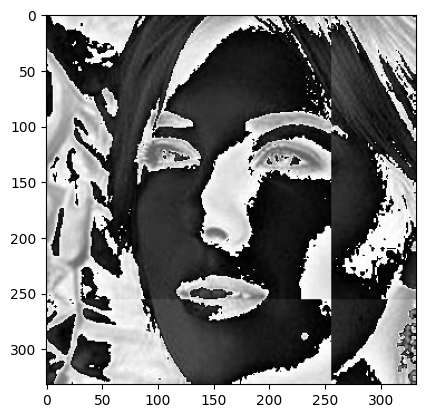

In [17]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /=255
    
    coeff = pywt.wavedec2(imArray, mode, level)
    
    coeff_H = list(coeff)
    coeff_H[0] *= 0
    imArray_H = pywt.waverec2(coeff_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [19]:
class_dict = {}
cnt = 0

for celebrity_name in celeb_file_name.keys():
    class_dict[celebrity_name] = cnt
    cnt += 1

class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [20]:
X = []
Y = []

for celebrity_name, training_files in celeb_file_name.items():
    for training_file in training_files:
        if os.path.exists(training_file):
            img = cv2.imread(training_file)
            scalled_raw_img = cv2.resize(img, (32,32))
            img_har = w2d(img, 'db1', 5)
            scalled_img_har = cv2.resize(img_har, (32,32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
            X.append(combined_img)
            Y.append(class_dict[celebrity_name])            

In [22]:
len(X)

162

In [24]:
len(Y)

162

In [25]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(162, 4096)

SVM

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=0, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8484848484848485

In [30]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.67      0.80         9
           2       1.00      1.00      1.00         4
           3       0.80      0.80      0.80         5
           4       0.71      1.00      0.83        10

    accuracy                           0.85        33
   macro avg       0.90      0.85      0.86        33
weighted avg       0.88      0.85      0.85        33



Grid Search CV for trying different model

In [32]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
model_param = {
    'svm' : {
        'model' : svm.SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C' : [1,10,100,1000],
            'svc__kernel' : ['rbf', 'linear']
        }
    },
    
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1,5,10]
        }
    },
    
    'logistic_regression' : {
        'model' : LogisticRegression(),
        'params' : {
            'logisticregression__C' : [1,5,10]
        }
    }
}

In [38]:
scores = []
best_estimators = {}

import pandas as pd
for algo, mp in model_param.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_param' : clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_param'])
df

c:\Users\Vedant\miniconda3_p11\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,model,best_score,best_param
0,svm,0.868000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.651077,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.867692,{'logisticregression__C': 1}


In [39]:
best_estimators['svm'].score(X_test, y_test)

0.9090909090909091

In [41]:
best_estimators['random_forest'].score(X_test, y_test)

0.7272727272727273

In [42]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9090909090909091

In [43]:
best_clf = best_estimators['svm']

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  0,  0,  1,  0],
       [ 0,  8,  1,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  1,  4,  0],
       [ 0,  0,  0,  0, 10]])

Text(95.72222222222221, 0.5, 'Truth')

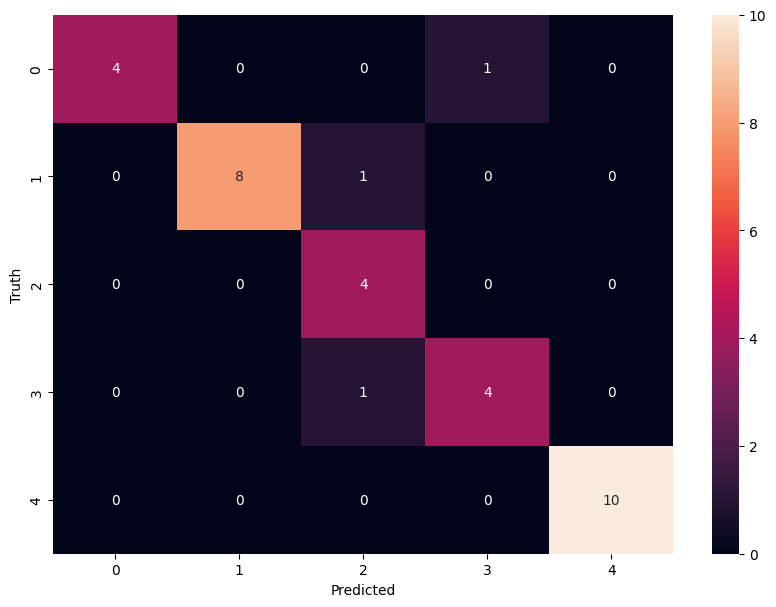

In [49]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [51]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [52]:
import json
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(class_dict))

In [1]:
def classify_fire_image(image_path):
    # Convert backslashes to forward slashes for consistency
    normalized_path = image_path.replace("\\", "/")
    
    # Check if the path contains "nofire"
    if "nofire" in normalized_path:
        return 1  # No fire
    else:
        return 0  # Fire

# Example usage
paths = [
    "D:/forest_fire/Training/fire/fire_0001.jpg",
    "D:/forest_fire/Training/fire/fire_0002.jpg",
    "D:/forest_fire/Training/fire/fire_0003.jpg",
    "D:/forest_fire/Training/fire/fire_0004.jpg",
    "D:/forest_fire/Training/fire/fire_0005.jpg",
    "D:/forest_fire/Training/fire/fire_0006.jpg",
    "D:/forest_fire/Training/fire/nofire_0007.jpg",
    "D:/forest_fire/Training/fire/nofire_0008.jpg",
    "D:/forest_fire/Training/fire/nofire_0009.jpg",
    "D:/forest_fire/Training/fire/nofire_0010.jpg",
    "D:/forest_fire/Training/fire/nofire_0011.jpg"
]

# Test the function
results = [classify_fire_image(path) for path in paths]
print(results)  # Output should be [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
